In [1]:
!python -V

Python 3.9.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import missingno as msno
from collections import Counter
%matplotlib inline

In [3]:
n = 8921483 #number of records in file
s = int(n/100) #desired sample size
random.seed(10)
skiprows = sorted(random.sample(range(1, n), n-s))
df = pd.read_csv('../data/raw/train.csv.gz', compression='gzip', skiprows=skiprows)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000a59784f4658c3a9820d801cc6e28,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1140.0,0,7.0,0,NaN,53447.0,...,21034.0,0,NaN,0.0,0,0,0.0,0.0,11.0,0
1,0002028c541ff91b6e5da2f5c24f681c,win8defender,1.1.15100.1,4.18.1806.18062,1.273.371.0,0,7.0,0,NaN,23657.0,...,20106.0,0,0.0,0.0,0,0,0.0,1.0,1.0,0
2,000218dfe2a12236d5df04b72caf445a,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1105.0,0,7.0,0,NaN,23962.0,...,66801.0,1,NaN,0.0,0,0,0.0,0.0,5.0,0
3,00034ca6e010a33b7fae245118e51138,win8defender,1.1.15100.1,4.9.10586.0,1.273.1405.0,0,7.0,0,NaN,46669.0,...,69498.0,1,0.0,0.0,0,0,0.0,0.0,10.0,1
4,0004273d2a0fa98a71102d01a6569130,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1208.0,0,7.0,0,NaN,53447.0,...,33120.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1


In [5]:
df.shape

(89214, 83)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89214 entries, 0 to 89213
Data columns (total 83 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MachineIdentifier                                  89214 non-null  object 
 1   ProductName                                        89214 non-null  object 
 2   EngineVersion                                      89214 non-null  object 
 3   AppVersion                                         89214 non-null  object 
 4   AvSigVersion                                       89214 non-null  object 
 5   IsBeta                                             89214 non-null  int64  
 6   RtpStateBitfield                                   88878 non-null  float64
 7   IsSxsPassiveMode                                   89214 non-null  int64  
 8   DefaultBrowsersIdentifier                          4424 non-null   float64
 9   AVProd

## Feature groups:

#### 1. Machine specs and OS:
- MachineIdentifier - Individual machine ID
- HasTpm - True if machine has tpm Trusted Platform Module (TPM)
- Platform - Calculates platform name (of OS related properties and processor property)
- Processor - This is the process architecture of the installed operating system
- OsVer - Version of the current operating system
- OsBuild - Build of the current operating system
- OsSuite - Product suite mask for the current operating system
- OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
- OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
- SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.

#### 2. Defender Specs:    
- ProductName - Defender state information e.g. win8defender
- EngineVersion - Defender state information e.g. 1.1.12603.0
- AppVersion - Defender state information e.g. 4.9.10586.0
- AvSigVersion - Defender state information e.g. 1.217.1014.0
- IsBeta - Defender state information e.g. false
 
#### 3. Anti Virus (AV) & Security Settings:
- AVProductStatesIdentifier - ID for the specific configuration of a  user's antivirus software
- AVProductsInstalled - NA
- AVProductsEnabled - NA
- IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
- PuaMode - Pua Enabled mode from the service
- SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
- SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry. This helps you identify reported phishing and malware websites and also helps you make informed decisions about downloads. 
- Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

#### 4. Browser & Apps:
- DefaultBrowsersIdentifier - ID for the machine's default browser
- IeVerIdentifier - NA - Should be Internet Explorer Version
- Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.

#### 5. Geographical:
- CountryIdentifier - ID for the country the machine is located in
- CityIdentifier - ID for the city the machine is located in
- OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
- GeoNameIdentifier - ID for the geographic region a machine is located in
- LocaleEnglishNameIdentifier - English name of Locale ID of the current user

#### 6. Census Data:
- Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
- Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
- Census_OEMNameIdentifier - NA
- Census_OEMModelIdentifier - NA
- Census_ProcessorCoreCount - Number of logical cores in the processor
- Census_ProcessorManufacturerIdentifier - NA
- Census_ProcessorModelIdentifier - NA
- Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
- Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
- Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
- Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
- Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
- Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
- Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
- Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
- Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
- Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
- Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
- Census_InternalBatteryType - NA
- Census_InternalBatteryNumberOfCharges - NA
- Census_OSVersion - Numeric OS version Example - 10.0.10130.0
- Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
- Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
- Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
- Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
- Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
- Census_OSSkuName - OS edition friendly name (currently Windows only)
- Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
- Census_OSInstallLanguageIdentifier - NA
- Census_OSUILocaleIdentifier - NA
- Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
- Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
- Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
- Census_ActivationChannel - Retail license key or Volume license key for a machine.
- Census_IsFlightingInternal - NA
- Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
- Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
- Census_ThresholdOptIn - NA
- Census_FirmwareManufacturerIdentifier - NA
- Census_FirmwareVersionIdentifier - NA
- Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
- Census_IsWIMBootEnabled - NA
- Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
- Census_IsTouchEnabled - Is this a touch device ?
- Census_IsPenCapable - Is the device capable of pen input ?
- Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .

#### 7. Unknown:
- RtpStateBitfield - NA
- IsSxsPassiveMode - NA
- AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

In [7]:
round(df.HasDetections.mean(), 2), df.HasDetections.isnull().sum()

(0.5, 0)

In [8]:
df.HasDetections.value_counts()

1    44691
0    44523
Name: HasDetections, dtype: int64

The dataset is balanced and there are no missing values in the target variable.

Check missing values:

In [9]:
missing_df = pd.concat([df.isnull().sum(), round(df.isnull().mean() * 100, 2)], axis=1)
missing_df.columns = ['missing_count', '%']
missing_df.sort_values(by='missing_count', ascending=False)[:15]

,missing_count,%
PuaMode,89193,99.98
Census_ProcessorClass,88823,99.56
DefaultBrowsersIdentifier,84790,95.04
Census_IsFlightingInternal,74134,83.10
Census_InternalBatteryType,63316,70.97
Census_ThresholdOptIn,56735,63.59
Census_IsWIMBootEnabled,56643,63.49
SmartScreen,32004,35.87
OrganizationIdentifier,27331,30.64
SMode,5462,6.12


In [10]:
missing_list = missing_df[missing_df['%']>40].index.tolist()
missing_list

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

In [11]:
df[missing_list].nunique()

DefaultBrowsersIdentifier     252
PuaMode                         1
Census_ProcessorClass           3
Census_InternalBatteryType     19
Census_IsFlightingInternal      1
Census_ThresholdOptIn           2
Census_IsWIMBootEnabled         1
dtype: int64

Drop variables with missing values > 40%

In [12]:
df = df.drop(missing_list, axis=1)

Check for duplicates:

In [13]:
df.duplicated(keep=False).sum()

0

In [14]:
df['MachineIdentifier'].nunique(), df.shape[0]

(89214, 89214)

Get rif of MachineIdentifier:

In [15]:
df = df.drop('MachineIdentifier', axis=1)

# Categorical Features

In [16]:
cat_col = df.select_dtypes('object').columns.tolist()
df[cat_col].head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,...,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1140.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.285,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,Volume:GVLK,Retail
1,win8defender,1.1.15100.1,4.18.1806.18062,1.273.371.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,...,10.0.17134.165,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail
2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1105.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail
3,win8defender,1.1.15100.1,4.9.10586.0,1.273.1405.0,windows10,x64,10.0.0.0,th2,10586.0.amd64fre.th2_release.151029-1700,Home,...,10.0.10586.0,amd64,th2_release,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,UNKNOWN,IS_GENUINE,OEM:DM,Retail
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1208.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,...,10.0.17134.48,amd64,rs4_release,ProfessionalN,PROFESSIONAL_N,IBSClean,UNKNOWN,IS_GENUINE,Retail,Unknown


In [17]:
df[cat_col].describe().T

,count,unique,top,freq
ProductName,89214,3,win8defender,88213
EngineVersion,89214,40,1.1.15200.1,38090
AppVersion,89214,73,4.18.1807.18075,51203
AvSigVersion,89214,3857,1.273.1420.0,1015
Platform,89214,4,windows10,86047
Processor,89214,3,x64,80989
OsVer,89214,8,10.0.0.0,86175
OsPlatformSubRelease,89214,9,rs4,38933
OsBuildLab,89214,355,17134.1.amd64fre.rs4_release.180410-1804,36318
SkuEdition,89214,8,Home,55186


In [18]:
n_unique_list = df[cat_col].nunique().sort_values(ascending=False)
n_unique_list[:20]

AvSigVersion                        3857
OsBuildLab                           355
Census_OSVersion                     252
AppVersion                            73
EngineVersion                         40
Census_ChassisTypeName                28
Census_OSEdition                      21
Census_OSSkuName                      20
Census_OSBranch                       15
Census_MDC2FormFactor                 11
SmartScreen                           11
OsPlatformSubRelease                   9
Census_PowerPlatformRoleName           9
Census_OSInstallTypeName               9
SkuEdition                             8
OsVer                                  8
Census_FlightRing                      7
Census_OSWUAutoUpdateOptionsName       6
Census_ActivationChannel               6
Census_GenuineStateName                4
dtype: int64

In [19]:
high_cardinality_features = n_unique_list[n_unique_list > 15]
high_cardinality_features.index.tolist()

['AvSigVersion',
 'OsBuildLab',
 'Census_OSVersion',
 'AppVersion',
 'EngineVersion',
 'Census_ChassisTypeName',
 'Census_OSEdition',
 'Census_OSSkuName']

In [20]:
for col in cat_col:
    print(f'Feature: {col} \nUnique Values Count: {df[col].nunique()}\nMissing Values Count: {df[col].isnull().sum()}\nValue counts:\n{df[col].value_counts()}\n\n')   

Feature: ProductName 
Unique Values Count: 3
Missing Values Count: 0
Value counts:
win8defender    88213
mse              1000
scep                1
Name: ProductName, dtype: int64


Feature: EngineVersion 
Unique Values Count: 40
Missing Values Count: 0
Value counts:
1.1.15200.1    38090
1.1.15100.1    36948
1.1.15000.2     2605
1.1.14901.4     2230
1.1.14600.4     1564
1.1.14800.3     1374
1.1.15300.6     1239
1.1.14104.0      958
1.1.13504.0      755
1.1.15300.5      663
1.1.14700.5      487
1.1.14500.5      475
1.1.14405.2      377
1.1.14306.0      256
1.1.14202.0      173
1.1.14003.0      124
1.1.13407.0      100
1.1.13804.0       95
1.1.13303.0       95
1.1.13903.0       93
1.1.13601.0       64
1.1.12902.0       62
1.1.14305.0       56
1.1.13202.0       51
1.1.13000.0       49
1.1.13704.0       45
1.1.13103.0       41
1.1.13701.0       38
1.1.12805.0       29
1.1.15000.1       22
1.1.14700.3       15
1.1.14700.4       10
1.1.14901.3       10
1.1.14800.1        8
1.1.14500.2      

Replace rare classes with nan:

In [21]:
df.loc[df.ProductName == 'scep', 'ProductName'] = np.nan
df.ProductName.unique(), df.ProductName.isnull().sum()

(array(['win8defender', 'mse', nan], dtype=object), 1)

In [22]:
df.loc[df.Processor == 'arm64', 'Processor'] = np.nan
df.Processor.unique(), df.Processor.isnull().sum()

(array(['x64', 'x86', nan], dtype=object), 5)

In [23]:
df.loc[df.OsVer == '6.1.0.0', 'OsVer'] = '6.1.1.0'
df.loc[df.OsVer == '10.0.3.0', 'OsVer'] = '10.0.0.0'
df.loc[df.OsVer == '10.0.0.2', 'OsVer'] = '10.0.0.0'
df.loc[df.OsVer == '10.0.7.0', 'OsVer'] = '10.0.0.0'
df.loc[df.OsVer == '10.0.1.0', 'OsVer'] = '10.0.0.0'
df.OsVer.value_counts()

10.0.0.0    86182
6.3.0.0      2040
6.1.1.0       992
Name: OsVer, dtype: int64

In [24]:
df.SkuEdition.value_counts()

Home               55186
Pro                32116
Invalid              814
Education            439
Enterprise           359
Enterprise LTSB      209
Cloud                 49
Server                42
Name: SkuEdition, dtype: int64

I am not changing SkuEdition for now, but might reduce to three clasess: Home, Pro, Others

In [25]:
df.SmartScreen.value_counts() 

RequireAdmin    43042
ExistsNotSet    10495
Off              1852
Warn             1261
Prompt            340
Block             193
off                11
On                  9
&#x01;              3
&#x02;              2
on                  2
Name: SmartScreen, dtype: int64

In [26]:
df.loc[df.SmartScreen == 'on', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'off', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == '&#x01;', 'SmartScreen'] = '&#x0_'
df.loc[df.SmartScreen == '&#x02;', 'SmartScreen'] = '&#x0_'
df.SmartScreen.value_counts() 

RequireAdmin    43042
ExistsNotSet    10495
Off              1863
Warn             1261
Prompt            340
Block             193
On                 11
&#x0_               5
Name: SmartScreen, dtype: int64

This is an important feature, need to think avout a smart encoding - maybe nominal. 

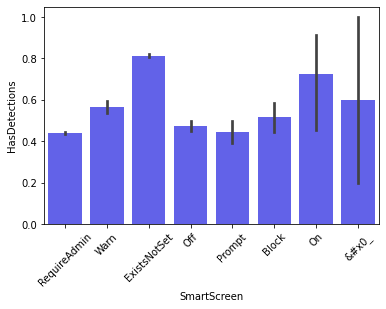

In [27]:
sns.barplot(x='SmartScreen', y='HasDetections', data=df, color='blue', alpha=.7)
plt.xticks(rotation=45);

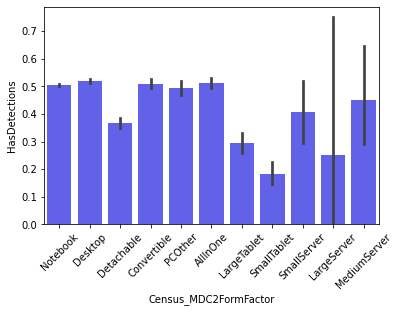

In [28]:
sns.barplot(x='Census_MDC2FormFactor', y='HasDetections', data=df, color='blue', alpha=.7)
plt.xticks(rotation=45);

Could group Tablets and Servers to reduce cardinality

In [29]:
df.loc[df.Census_DeviceFamily == 'Windows', 'Census_DeviceFamily'] = np.nan
df.Census_DeviceFamily.unique(), df.Census_DeviceFamily.isnull().sum()

(array(['Windows.Desktop', 'Windows.Server', nan], dtype=object), 1)

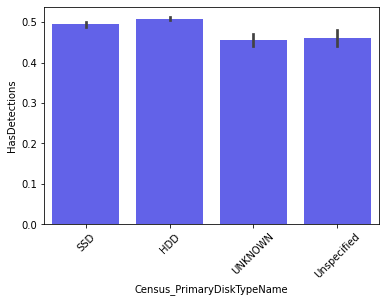

In [30]:
sns.barplot(x='Census_PrimaryDiskTypeName', y='HasDetections', data=df, color='blue', alpha=.7)
plt.xticks(rotation=45); 

This feature is probably useless, will merge UNKNOWN and Unspecified

In [31]:
df.loc[df.Census_PrimaryDiskTypeName == 'UNKNOWN', 'Census_PrimaryDiskTypeName'] = 'Unspecified'
df.Census_PrimaryDiskTypeName.unique(), df.Census_PrimaryDiskTypeName.isnull().sum()

(array(['SSD', 'HDD', 'Unspecified', nan], dtype=object), 141)

In [32]:
df.loc[df.Census_ChassisTypeName == 'UNKNOWN', 'Census_ChassisTypeName'] = 'Unknown'
df.Census_ChassisTypeName.unique(), df.Census_ChassisTypeName.isnull().sum()

(array(['Laptop', 'Desktop', 'Notebook', 'Detachable', 'Convertible',
        'Portable', 'AllinOne', 'LowProfileDesktop', 'Unknown',
        'MiniTower', 'Tablet', 'Other', 'MainServerChassis', 'HandHeld',
        'SpaceSaving', 'RackMountChassis', 'IoTGateway', 'Tower',
        'LunchBox', 'SubNotebook', 'MiniPC', '30', 'BusExpansionChassis',
        '127', 'SubChassis', nan, '81', '0'], dtype=object),
 3)

In [33]:
df.loc[df.Census_OSArchitecture == 'arm64', 'Census_OSArchitecture'] = np.nan
df.Census_OSArchitecture.unique(), df.Census_OSArchitecture.isnull().sum()

(array(['amd64', 'x86', nan], dtype=object), 5)

# Numerical features

In [34]:
num_col = [col for col in df.columns.tolist() if col not in cat_col]
df[num_col].head()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,7.0,0,53447.0,1.0,1.0,1,94,65823.0,NaN,...,355.0,21034.0,0,0.0,0,0,0.0,0.0,11.0,0
1,0,7.0,0,23657.0,2.0,1.0,1,139,87570.0,NaN,...,355.0,20106.0,0,0.0,0,0,0.0,1.0,1.0,0
2,0,7.0,0,23962.0,2.0,1.0,1,123,94381.0,NaN,...,440.0,66801.0,1,0.0,0,0,0.0,0.0,5.0,0
3,0,7.0,0,46669.0,2.0,1.0,1,85,NaN,27.0,...,142.0,69498.0,1,0.0,0,0,0.0,0.0,10.0,1
4,0,7.0,0,53447.0,1.0,1.0,1,50,105713.0,27.0,...,554.0,33120.0,0,0.0,0,0,0.0,0.0,3.0,1


In [35]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
IsBeta,89214.0,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.000000e+00,0.000000e+00
RtpStateBitfield,88878.0,6.847263e+00,1.018277e+00,0.0,7.00,7.0,7.000000e+00,8.000000e+00
IsSxsPassiveMode,89214.0,1.681350e-02,1.285729e-01,0.0,0.00,0.0,0.000000e+00,1.000000e+00
AVProductStatesIdentifier,88849.0,4.786345e+04,1.401683e+04,23.0,49480.00,53447.0,5.344700e+04,7.046900e+04
AVProductsInstalled,88849.0,1.325519e+00,5.220829e-01,1.0,1.00,1.0,2.000000e+00,6.000000e+00
AVProductsEnabled,88849.0,1.021362e+00,1.676583e-01,0.0,1.00,1.0,1.000000e+00,5.000000e+00
HasTpm,89214.0,9.875356e-01,1.109468e-01,0.0,1.00,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,89214.0,1.076928e+02,6.289845e+01,1.0,51.00,97.0,1.600000e+02,2.220000e+02
CityIdentifier,85951.0,8.125057e+04,4.902199e+04,41.0,36825.00,82373.0,1.240210e+05,1.679530e+05
OrganizationIdentifier,61883.0,2.490361e+01,5.580480e+00,1.0,18.00,27.0,2.700000e+01,5.200000e+01


In [36]:
df.IsProtected.unique()

array([ 1.,  0., nan])

IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.

Change encoding:

In [37]:
df.IsProtected = df.IsProtected.map({np.nan:0, 0:1, 1:2})
df.IsProtected.unique()

array([2, 1, 0], dtype=int64)

In [38]:
df.IsProtected.describe()

count    89214.000000
mean         1.937667
std          0.258087
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: IsProtected, dtype: float64

In [39]:
binary_feat = [col for col in num_col if df[col].nunique() <= 2]
binary_feat

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

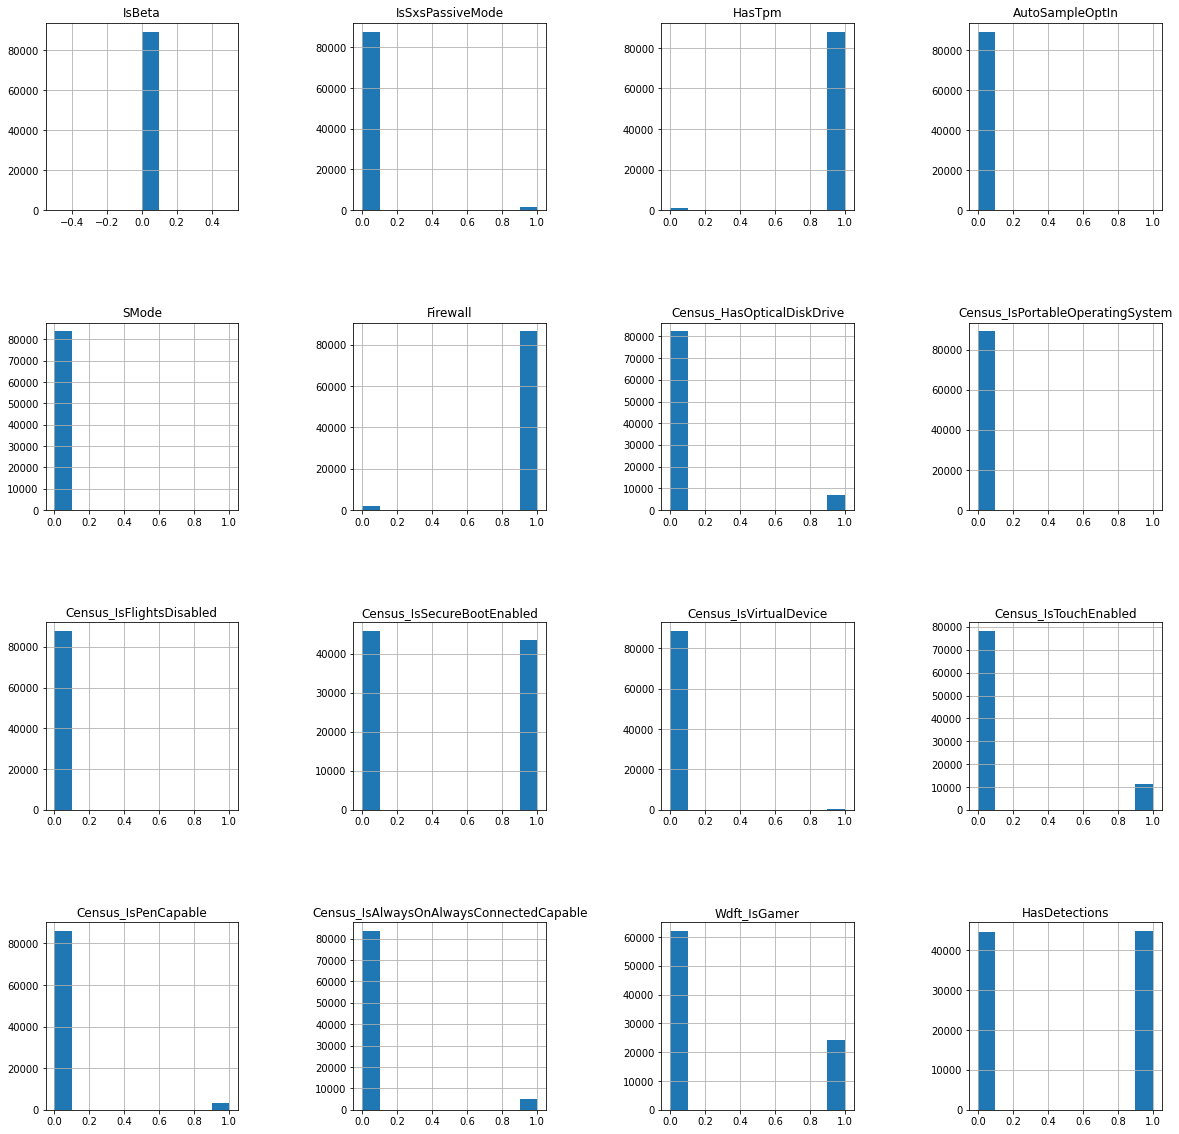

In [40]:
df[binary_feat].hist(figsize=(20, 20))
plt.subplots_adjust(hspace=.6, wspace=.6)

In [41]:
to_drop = [feat for feat in binary_feat if df[feat].var() < .01]
to_drop

['IsBeta',
 'AutoSampleOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsVirtualDevice']

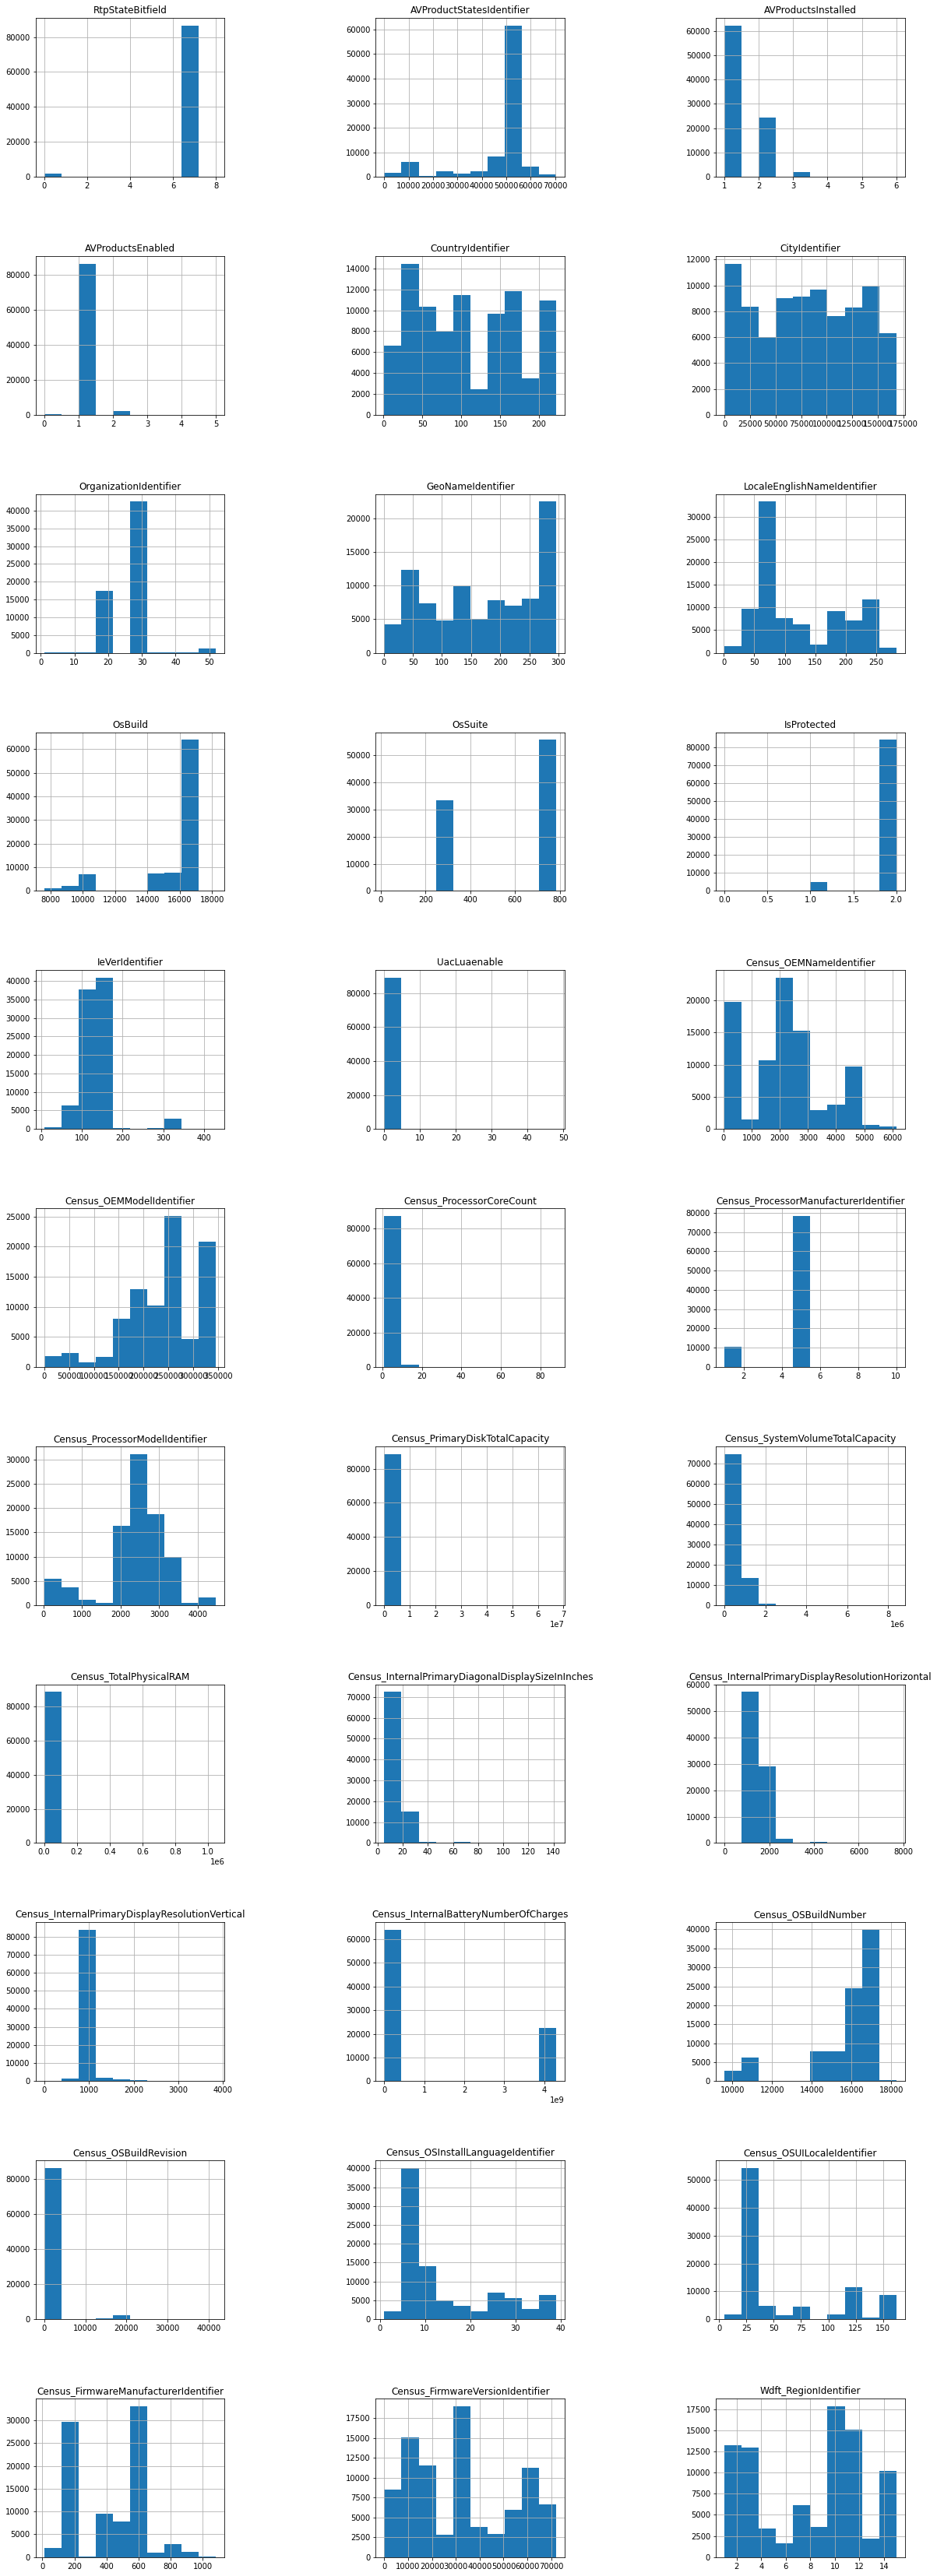

In [42]:
df.loc[:, ~df.columns.isin(binary_feat)].hist(figsize=(20, 60), layout=(11, 3))
plt.subplots_adjust(hspace=.5, wspace=.8)

Summary of numerical features and potential issues:
   - **RtpStateBitfield**: no info in metadata. The most frequent value is 7.
   - **AVProductStatesIdentifier**: these are ID's for the specific configuration of a user's antivirus software. Should treat it as categorical feature. Most ID values around 53000.
   - **AVProductsInstalled** and **AVProductsEnabled**: no info in metadata. Probably a count of Anti Virus Products Installed and Enabled. Likely correlated. Most of values are 1 or 2 then large left skew. 
   - **CountryIdentifier**, **CityIdentifier**,  **GeoNameIdentifier**, **LocaleEnglishNameIdentifier**: these are all ID's taking many values and all related to physical location of a machine.
   - **OrganizationIdentifier**: ID for the organization the machine belongs in. Most values are 20 and 30, could reduce to three classes: 20, 30, others.
   - **OsBuild** and **OsSuite**: these are again ID's of Product build and suite mask for the current operating system. OsSuite has mainly two classes.
   - **IeVerIdentifier** no info in metadata. Might have outliers  for values > 300.
   - **UacLuaenable**: has outliers and/or extremely rare values.
   - **Census_OEMNameIdentifier**, **Census_OEMModelIdentifier**: no info in metadata. Should be ID for original equipment manufacturer OEM name and model.
   - **Census_ProcessorCoreCount**: Actual number of logical cores in the processor. Most machines have < 20 cores. There are outliers maybe because of supercomputers.
   - **Census_ProcessorManufacturerIdentifier**, **Census_ProcessorModelIdentifier**: no info in metadata. Should be ID for processor manufacturer and model.
   - **Census_PrimaryDiskTotalCapacity**, **Census_SystemVolumeTotalCapacity**, **Census_TotalPhysicalRAM**: these are actual numerics in MB of memory. They are likely correlated and have outliers.
   - **Census_InternalPrimaryDiagonalDisplaySizeInInches**, **Census_InternalPrimaryDisplayResolutionHorizontal**, **Census_InternalPrimaryDisplayResolutionVertical**: these are dims and resolution of display. Should not be correlated with malware infections. Contain outliers.
   - **Census_InternalBatteryNumberOfCharges**: no info in metadata. It has mostly very small or very big values. Might convert it to binary feature.
   - All features with "OS" or "Os", i.e. those related to Operating System, present repetitions since some have been extracted from **OsVer** and **OsBuildLab**. I will need to drop these repetitions.
   - **Census_FirmwareManufacturerIdentifier**, **Census_FirmwareVersionIdentifier**no info in metadata. Should be ID's of Firmware Manufacturer and version.
   - **Wdft_RegionIdentifier**: no info in metadata. Should be another ID.
   
    Key points:
    1. Many features have outliers / extremely skewed distributions  
    2. A few features are repeted / duplicates of other categorical features - see OS features
    3. Most of the numerical features are actually categories / ID's encoded as numbers
    4. Actual numerical features are: 
        - Census_ProcessorCoreCount
        - Census_PrimaryDiskTotalCapacity
        - Census_SystemVolumeTotalCapacity
        - Census_TotalPhysicalRAM
        - Census_InternalPrimaryDiagonalDisplaySizeInInches
        - Census_InternalPrimaryDisplayResolutionHorizontal
        - Census_InternalPrimaryDisplayResolutionVertical
        - Census_InternalBatteryNumberOfCharges

Let's fix some of this problems, starting with checking obvious outliers and extremely skewed distributions. I will add the features which are not usefull to the analysis to the list to_drop and fix outliers for the other features which may have predictive power.

**RtpStateBitfiels**

In [43]:
pd.crosstab(df.RtpStateBitfield, df.HasDetections, margins=True)

HasDetections,0,1,All
RtpStateBitfield,,,
0.0,1128,754,1882
1.0,6,8,14
3.0,19,14,33
5.0,159,35,194
7.0,42972,43580,86552
8.0,57,146,203
All,44341,44537,88878


**UacLuaenable**

In [44]:
pd.crosstab(df.UacLuaenable, df.HasDetections, margins=True)

HasDetections,0,1,All
UacLuaenable,,,
0.0,277,259,536
1.0,44191,44362,88553
48.0,2,2,4
All,44470,44623,89093


In [45]:
to_drop.append('UacLuaenable')

**AVProductsEnabled**

In [46]:
pd.crosstab(df.AVProductsEnabled, df.HasDetections, margins=True) 

HasDetections,0,1,All
AVProductsEnabled,,,
0.0,155,90,245
1.0,42783,43747,86530
2.0,1325,685,2010
3.0,41,19,60
4.0,3,0,3
5.0,1,0,1
All,44308,44541,88849


**Census_ProcessorCoreCount**

<AxesSubplot:>

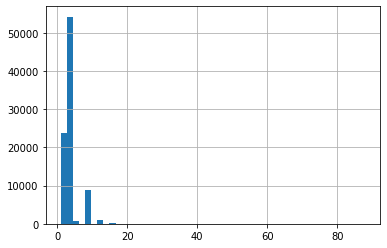

In [47]:
df.Census_ProcessorCoreCount.hist(bins=50)

In [48]:
pd.crosstab(df.Census_ProcessorCoreCount, df.HasDetections, margins=True) 

HasDetections,0,1,All
Census_ProcessorCoreCount,,,
1.0,489,232,721
2.0,12483,10680,23163
3.0,62,69,131
4.0,26590,27514,54104
5.0,2,1,3
6.0,287,383,670
7.0,0,2,2
8.0,3889,4835,8724
10.0,1,0,1


Very few machines have more than 16 cores. I will not change this feature for now.

**Census_PrimaryDiskTotalCapacity**

<AxesSubplot:>

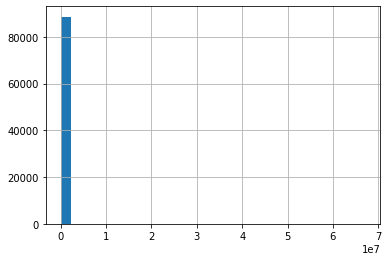

In [49]:
df.Census_PrimaryDiskTotalCapacity.hist(bins=30)

Use 16 TB = 16 $\times$ 10$^{6}$ MB as limit for outliers

In [50]:
limit = 16*10**6
df.loc[df['Census_PrimaryDiskTotalCapacity'] > limit, 'Census_PrimaryDiskTotalCapacity']

49628    67108864.0
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

<AxesSubplot:>

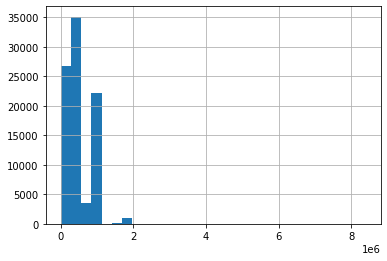

In [51]:
df.loc[df['Census_PrimaryDiskTotalCapacity'] > limit, 'Census_PrimaryDiskTotalCapacity'] = np.nan
df.Census_PrimaryDiskTotalCapacity.hist(bins=30)

**Census_SystemVolumeTotalCapacity**

<AxesSubplot:>

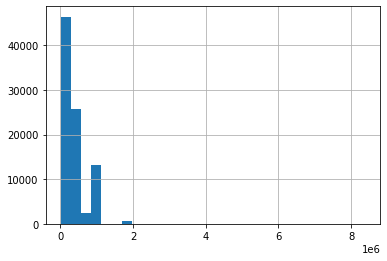

In [52]:
df.Census_SystemVolumeTotalCapacity.hist(bins=30)

<AxesSubplot:>

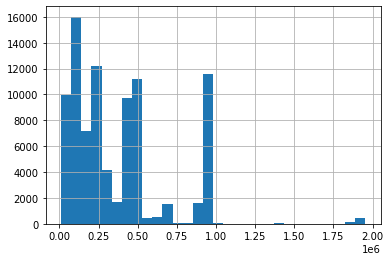

In [53]:
vol_limit = 2e6
df.loc[df['Census_SystemVolumeTotalCapacity'] > vol_limit, 'Census_SystemVolumeTotalCapacity'] = np.nan
df.Census_SystemVolumeTotalCapacity.hist(bins=30)

**Census_TotalPhysicalRAM**

<AxesSubplot:>

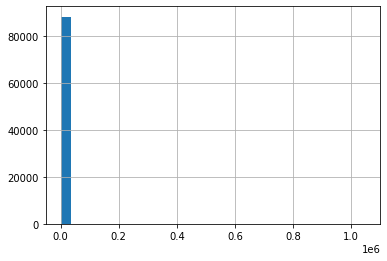

In [54]:
df.Census_TotalPhysicalRAM.hist(bins=30)

In [55]:
df.Census_TotalPhysicalRAM.value_counts()

4096.0      40997
8192.0      21808
2048.0      10939
16384.0      5358
6144.0       4101
            ...  
153599.0        1
4024.0          1
10578.0         1
6955.0          1
6207.0          1
Name: Census_TotalPhysicalRAM, Length: 179, dtype: int64

In [56]:
bins = [0,
        2_000,
        4_000,
        8_000,
        16_000,
        32_000,
        64_000,
        128_000,
        192_000,
        512_000,
        1_000_000,
        np.inf]
labels = ['0-2 GB', '2-4 GB', '4-8 GB', '8-16 GB',
          '16-32 GB', '32-64 GB', '64-128 GB', 
          '128-192 GB',  '192-512 GB', '512-1000 GB', 
          '1+ TB']

RAM_bins_df = pd.cut(df.Census_TotalPhysicalRAM,
                     bins=bins,
                     labels=labels)
RAM_bins_df.value_counts()

4-8 GB         45293
8-16 GB        23533
2-4 GB         12565
16-32 GB        5556
0-2 GB           743
32-64 GB         618
64-128 GB         65
128-192 GB        12
192-512 GB         3
512-1000 GB        1
1+ TB              1
Name: Census_TotalPhysicalRAM, dtype: int64

In [57]:
df.Census_TotalPhysicalRAM.max()

1048576.0

Max of about 1 TB is possible for RAM of Windows Servers

**Census_InternalPrimaryDiagonalDisplaySizeInInches**

<AxesSubplot:>

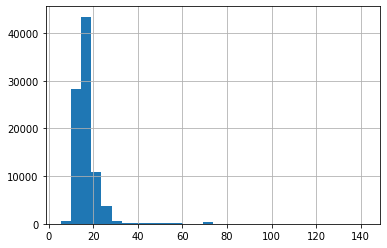

In [58]:
df.Census_InternalPrimaryDiagonalDisplaySizeInInches.hist(bins=30)

Screens with diagonal > 80 inches are rare but a max of 140 inches is possible. Will keep it as is. 

**Census_InternalPrimaryDisplayResolutionHorizontal** and **Census_InternalPrimaryDisplayResolutionVertical**

<AxesSubplot:>

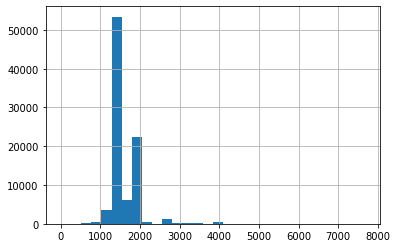

In [59]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.hist(bins=30)

In [60]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.max()

7680.0

<AxesSubplot:>

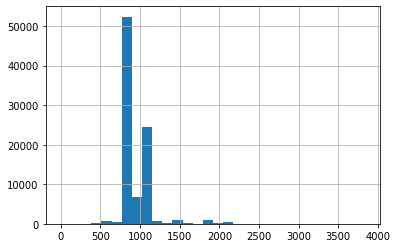

In [61]:
df.Census_InternalPrimaryDisplayResolutionVertical.hist(bins=30)

In [62]:
resolution = ['Census_InternalPrimaryDisplayResolutionHorizontal', 
              'Census_InternalPrimaryDisplayResolutionVertical']
df[df.Census_InternalPrimaryDisplayResolutionHorizontal >5240][resolution]

,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical
8149,5760.0,1080.0
29779,7680.0,1080.0
69292,5760.0,1080.0
87009,5760.0,1080.0


Index 29779 with 7680.0 pixels is a possible value. Keep it for now. 

**Census_InternalBatteryNumberOfCharges**

<AxesSubplot:>

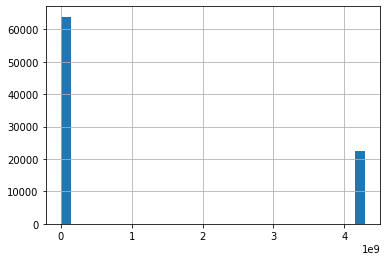

In [63]:
df.Census_InternalBatteryNumberOfCharges.hist(bins=30)

In [64]:
battery_charges_count = df.Census_InternalBatteryNumberOfCharges.value_counts()
battery_charges_count[:20]

0.000000e+00    50507
4.294967e+09    22452
1.000000e+00      536
1.600000e+01      300
2.000000e+00      291
3.000000e+00      223
3.300000e+01      206
4.000000e+00      188
5.000000e+00      173
7.000000e+00      147
6.000000e+00      143
4.294967e+09      128
4.380000e+02      127
1.000000e+01      123
3.740000e+02      123
1.500000e+01      118
8.000000e+00      117
9.000000e+00      105
1.400000e+01      103
2.560000e+02      100
1.300000e+01       97
2.100000e+01       95
1.200000e+01       94
1.100000e+01       92
3.770000e+02       92
2.400000e+01       91
1.800000e+01       90
2.200000e+01       89
1.900000e+01       84
1.700000e+01       83
3.840000e+02       75
2.300000e+01       75
3.500000e+01       74
2.600000e+01       74
2.500000e+01       74
4.350000e+02       73
2.000000e+01       71
Name: Census_InternalBatteryNumberOfCharges, dtype: int64

There is no info about this column, and most values are 0 or 4e9. 

Features regarding OS: check for repetitions of features extracted by **OsBuildLab**

In [65]:
df.loc[:, df.columns.str.contains('OS|Os|os', regex=True)]

,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName
0,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.285,amd64,rs4_release,17134,285,Professional,PROFESSIONAL,UUPUpgrade,8.0,31,FullAuto
1,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,8.0,31,FullAuto
2,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,14.0,49,FullAuto
3,10.0.0.0,10586,768,th2,10586.0.amd64fre.th2_release.151029-1700,10.0.10586.0,amd64,th2_release,10586,0,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,NaN,34,UNKNOWN
4,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.48,amd64,rs4_release,17134,48,ProfessionalN,PROFESSIONAL_N,IBSClean,3.0,20,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89209,10.0.0.0,16299,256,rs3,16299.15.amd64fre.rs3_release.170928-1534,10.0.16299.248,amd64,rs3_release,16299,248,Professional,PROFESSIONAL,UUPUpgrade,33.0,140,Notify
89210,10.0.0.0,16299,256,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,Professional,PROFESSIONAL,Upgrade,8.0,31,UNKNOWN
89211,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.81,amd64,rs4_release,17134,81,CoreSingleLanguage,CORE_SINGLELANGUAGE,UUPUpgrade,8.0,31,UNKNOWN
89212,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.285,amd64,rs4_release,17134,285,CoreSingleLanguage,CORE_SINGLELANGUAGE,Refresh,8.0,31,FullAuto


In [66]:
df.OsBuildLab.nunique()

355

**OsBuildLab** has very high cardinality. It seems many features are generated by extracting substrings from **OsBuildLab**, e.g. **OsBuild**, **Census_OSArchitecture**, **OsPlatformSubRelease**, etc. Check if these is correct and eliminate redundant features.

**OsPlatformSubRelease**

In [67]:
temp_df = pd.DataFrame()
temp_df['OsBuildLab'] = df['OsBuildLab']
temp_df['OsBuild'] = temp_df.OsBuildLab.str.split('.').str.get(0).astype('int')
temp_df['OsPlatformSubRelease'] = temp_df.OsBuildLab.str.split('.').str.get(3).str.split('_').str.get(0)
temp_df['Census_OSArchitecture'] = temp_df.OsBuildLab.str.split('.').str.get(2).str.replace('fre', '')
temp_df['Census_OSBranch'] = temp_df.OsBuildLab.str.split('.').str.get(3)
temp_df.head()

,OsBuildLab,OsBuild,OsPlatformSubRelease,Census_OSArchitecture,Census_OSBranch
0,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
1,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
2,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
3,10586.0.amd64fre.th2_release.151029-1700,10586,th2,amd64,th2_release
4,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release


In [68]:
for col in temp_df.columns:
    if col != 'OsBuildLab':
        print(f'{round(np.mean(df[col] != temp_df[col])*100 ,2)}% of {col} entries are different')

0.0% of OsBuild entries are different
3.66% of OsPlatformSubRelease entries are different
0.17% of Census_OSArchitecture entries are different
11.83% of Census_OSBranch entries are different


In [69]:
def compare_feature(col_name):
    ''' 
    Reads column name (str) 
    Returns a df summarizing comparing original and 
    extracted features, a list of tuples containing the 
    different element, and the count of different elements
    '''
    df_1 = pd.DataFrame(df[df[col_name] != temp_df[col_name]][['OsBuildLab', col_name]].values, columns=['OsBuildLab', col_name+'1'])
    df_2 = pd.DataFrame(temp_df[df[col_name] != temp_df[col_name]][col_name].values, columns=[col_name+'2'])
    comparison_df = pd.concat([df_1, df_2], axis=1)
    comp_list = list(zip(comparison_df.iloc[:, 1], comparison_df.iloc[:, 2]))

    return comparison_df, comp_list, Counter(comp_list)

In [70]:
comparison_df, comp_list, tuple_counts = compare_feature('OsPlatformSubRelease')

In [71]:
comparison_df.head()

,OsBuildLab,OsPlatformSubRelease1,OsPlatformSubRelease2
0,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
1,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
2,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
3,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
4,9600.18969.amd64fre.winblue_ltsb.180309-0600,windows8.1,winblue


In [72]:
comp_list

[('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('windows8.1', 'winblue'),
 ('prers5', 'rs5'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('windows7', 'win7sp1'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('prers5', 'rs5'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('windows7', 'win7sp1'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows8.1', 'winblue'),
 ('windows7', 'win7sp1'),
 ('windows8.1', 'winblue'),
 

In [73]:
tuple_counts

Counter({('windows8.1', 'winblue'): 2040,
         ('windows7', 'win7sp1'): 983,
         ('prers5', 'rs5'): 165,
         ('windows7', 'win7'): 9,
         ('prers5', 'rs'): 65})

It looks like the values are consistent.

In [74]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSArchitecture')
tuple_counts

Counter({('amd64', 'x86'): 66, ('x86', 'amd64'): 79, (nan, 'arm64'): 5})

It looks like the the 64 and 32 bits are switched occasionally.

In [75]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSBranch')
comparison_df

,OsBuildLab,Census_OSBranch1,Census_OSBranch2
0,10240.17443.amd64fre.th1.170602-2340,th1_st1,th1
1,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,th2_release,winblue_ltsb_escrow
2,14393.1198.amd64fre.rs1_release_sec.170427-1353,rs1_release,rs1_release_sec
3,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,rs1_release,winblue_ltsb_escrow
4,10586.420.x86fre.th2_release_sec.160527-1834,th2_release,th2_release_sec
...,...,...,...
10549,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,th2_release,winblue_ltsb_escrow
10550,16299.637.amd64fre.rs3_release_svc.180808-1748,rs3_release,rs3_release_svc
10551,7601.24214.amd64fre.win7sp1_ldr_escrow.180801-...,th2_release,win7sp1_ldr_escrow
10552,16299.15.amd64fre.rs3_release.170928-1534,rs1_release,rs3_release


In [76]:
tuple_counts

Counter({('th1_st1', 'th1'): 1813,
         ('th2_release', 'winblue_ltsb_escrow'): 750,
         ('rs1_release', 'rs1_release_sec'): 380,
         ('rs1_release', 'winblue_ltsb_escrow'): 343,
         ('th2_release', 'th2_release_sec'): 741,
         ('rs1_release', 'rs1_release_inmarket'): 1069,
         ('rs4_release', 'rs3_release'): 448,
         ('rs1_release', 'rs1_release_inmarket_aim'): 63,
         ('rs4_release', 'rs3_release_svc_escrow'): 419,
         ('rs1_release', 'rs1_release_1'): 422,
         ('rs1_release', 'winblue_ltsb'): 109,
         ('th2_release', 'win7sp1_ldr'): 400,
         ('th2_release_sec', 'th2_release'): 472,
         ('rs3_release_svc_escrow', 'rs4_release'): 94,
         ('rs2_release', 'winblue_ltsb_escrow'): 100,
         ('rs3_release', 'rs3_release_svc_escrow'): 376,
         ('rs3_release_svc_escrow', 'rs3_release'): 111,
         ('rs3_release', 'rs4_release'): 109,
         ('rs3_release', 'rs3_release_svc'): 467,
         ('th2_release', 'th1

There are more incosistencies here. I will drop **OsBuildLab** after extracting the **branch release**

In [77]:
df['Census_OSBranch_release_extracted'] = df.OsBuildLab.str.split('.').str.get(3)
df['Census_OSBranch_release_extracted']

0                   rs4_release
1                   rs4_release
2                   rs4_release
3                   th2_release
4                   rs4_release
                  ...          
89209               rs3_release
89210    rs3_release_svc_escrow
89211               rs4_release
89212               rs4_release
89213               rs4_release
Name: Census_OSBranch_release_extracted, Length: 89214, dtype: object

In [78]:
to_drop.append('OsBuildLab')

**OsBuild** and **Census_OSBuildNumber** likely carry same info:

In [79]:
df[df.OsBuild != df.Census_OSBuildNumber][['OsBuild', 'Census_OSBuildNumber']]

,OsBuild,Census_OSBuildNumber
56,9600,10586
63,9600,14393
92,9600,14393
107,9600,10586
117,16299,17134
...,...,...
89150,7601,10586
89156,9600,10586
89160,9600,10586
89172,7601,10586


In [80]:
np.mean(df.OsBuild != df.Census_OSBuildNumber)

0.050967336965050326

In [81]:
df.OsBuild.corr(df.Census_OSBuildNumber)

0.9384602443775911

In [82]:
to_drop.append('Census_OSBuildNumber')

**Census_OSBranch** and **OsPlatformSubRelease**  likely carry same info:

In [83]:
df[df.Census_OSBranch != df.OsPlatformSubRelease][['Census_OSBranch', 'OsPlatformSubRelease']]

,Census_OSBranch,OsPlatformSubRelease
0,rs4_release,rs4
1,rs4_release,rs4
2,rs4_release,rs4
3,th2_release,th2
4,rs4_release,rs4
...,...,...
89209,rs3_release,rs3
89210,rs3_release_svc_escrow,rs3
89211,rs4_release,rs4
89212,rs4_release,rs4


In [84]:
np.mean(df.Census_OSBranch.str.split('_').str.get(0) != df.OsPlatformSubRelease)

0.053141883560876096

In [85]:
to_drop.append('Census_OSBranch')

In [86]:
to_drop

['IsBeta',
 'AutoSampleOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsVirtualDevice',
 'UacLuaenable',
 'OsBuildLab',
 'Census_OSBuildNumber',
 'Census_OSBranch']

In [87]:
df = df.drop(to_drop, axis=1)

In [88]:
df.shape

(89214, 66)

In [89]:
numerical_col = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
binary_col = [col for col in binary_feat if col not in to_drop]
categorical_col = [col for col in df.columns.tolist() if col not in to_drop
                  if col not in numerical_col if col not in binary_col]

In [90]:
tot_col = numerical_col + binary_col + categorical_col
len(tot_col)

66

In [91]:
len(set(tot_col))

66

<AxesSubplot:>

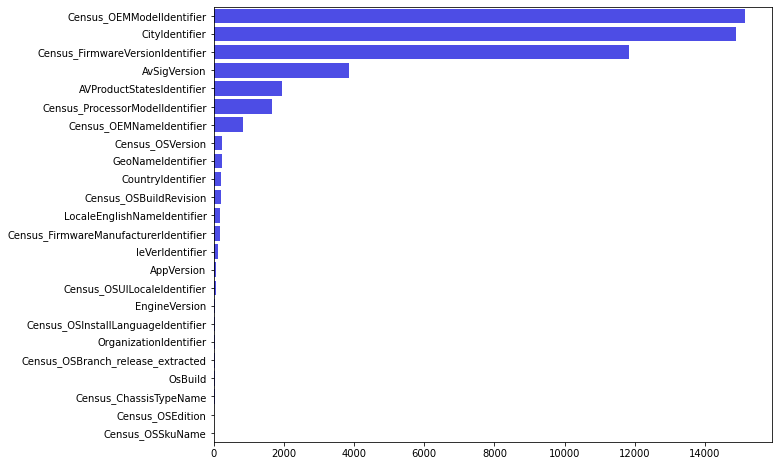

In [92]:
cardinality = df[categorical_col].nunique().sort_values(ascending=False)
plt.figure(figsize=(10,8))
high_cardinality = cardinality[cardinality > 15]
sns.barplot(y=high_cardinality.index, 
            x=high_cardinality.values, 
            orient='h', 
            color='b', 
            alpha=.8)

In [93]:
def get_rank(col_name):
    c_dict = Counter(df[col_name])
    return df[col_name].map(c_dict).replace(0, np.nan).rank()

In [94]:
Census_OEMModelIdentifier_Rank = get_rank('Census_OEMModelIdentifier')
Census_OEMModelIdentifier_Rank

0        59237.5
1        41450.5
2        10776.5
3        54706.5
4        63831.5
          ...   
89209    32913.0
89210    20779.5
89211     4423.5
89212        NaN
89213    83872.0
Name: Census_OEMModelIdentifier, Length: 89214, dtype: float64

In [95]:
#modified from: https://wrosinski.github.io/fe_categorical_encoding/
        
def labelcount_encode(X, categorical_features, ascending=False):
    print('LabelCount encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = X[cat_feature].fillna(0).value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        if ascending:
            # for ascending ordering
            value_counts_range = list(
                reversed(range(len(cat_feature_value_counts))))
        else:
            # for descending ordering
            value_counts_range = list(range(len(cat_feature_value_counts)))
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        X_[cat_feature] = X[cat_feature].fillna(0).map(
            labelcount_dict)
    X_ = X_.add_suffix('_encoded')
    X_ = X_.astype(np.uint32)
    return X_

In [96]:
df_encoded = labelcount_encode(df, high_cardinality.index)
df_encoded.head()

LabelCount encoding: Index(['Census_OEMModelIdentifier', 'CityIdentifier',
       'Census_FirmwareVersionIdentifier', 'AvSigVersion',
       'AVProductStatesIdentifier', 'Census_ProcessorModelIdentifier',
       'Census_OEMNameIdentifier', 'Census_OSVersion', 'GeoNameIdentifier',
       'CountryIdentifier', 'Census_OSBuildRevision',
       'LocaleEnglishNameIdentifier', 'Census_FirmwareManufacturerIdentifier',
       'IeVerIdentifier', 'AppVersion', 'Census_OSUILocaleIdentifier',
       'EngineVersion', 'Census_OSInstallLanguageIdentifier',
       'OrganizationIdentifier', 'Census_OSBranch_release_extracted',
       'OsBuild', 'Census_ChassisTypeName', 'Census_OSEdition',
       'Census_OSSkuName'],
      dtype='object')


,Census_OEMModelIdentifier_encoded,CityIdentifier_encoded,Census_FirmwareVersionIdentifier_encoded,AvSigVersion_encoded,AVProductStatesIdentifier_encoded,Census_ProcessorModelIdentifier_encoded,Census_OEMNameIdentifier_encoded,Census_OSVersion_encoded,GeoNameIdentifier_encoded,CountryIdentifier_encoded,...,AppVersion_encoded,Census_OSUILocaleIdentifier_encoded,EngineVersion_encoded,Census_OSInstallLanguageIdentifier_encoded,OrganizationIdentifier_encoded,Census_OSBranch_release_extracted_encoded,OsBuild_encoded,Census_ChassisTypeName_encoded,Census_OSEdition_encoded,Census_OSSkuName_encoded
0,131,445,529,3,0,323,2,3,63,57,...,0,0,0,0,1,0,0,2,1,1
1,546,249,22,5,7,151,2,1,0,133,...,1,0,1,0,1,0,0,1,0,0
2,5994,1054,6896,174,87,277,19,0,198,182,...,0,4,0,4,1,0,0,1,1,1
3,197,0,299,132,11,3,5,34,60,69,...,11,1,1,20,0,8,4,0,2,2
4,83,1027,102,45,0,139,3,25,30,37,...,0,19,1,19,0,0,0,0,7,6


In [97]:
df_encoded.shape

(89214, 24)

In [98]:
df.shape

(89214, 66)

In [99]:
df_clean = pd.concat([df.drop(high_cardinality.index, axis=1), df_encoded], axis=1)
df_clean.shape

(89214, 66)

In [100]:
df_clean.to_csv('../data/interim/train_clean.csv', index = False)